In [1]:
from src.utils import data_load
import pandas as pd
import matplotlib.pyplot as plt
from src.s3_utils import pandas_from_csv_s3
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import re
import datetime
import seaborn as sns
import numpy as np
from collections import defaultdict
import os
import pickle

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-i2cxenep because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
keys = {'oura_sleep', 'oura_activity', 'oura_readiness', 'birth'}
data = data_load(data_keys=keys, wave=5)

In [4]:
data['birth'].columns

Index(['record_id', 'redcap_event_name_x', 'birth_number', 'birth_date',
       'birth_scheduled', 'birth_scheduled_unsure', 'birth_gestage',
       'birth_mode', 'induction_yn', 'induction_reason', 'vacuumforceps',
       'vaginalaftercesarean', 'birth_c_type', 'birth_incision',
       'birth_indication', 'birth_apgar1', 'birth_apgar2', 'birth_abnormal1',
       'birth_describe1', 'conditionsknown', 'birth_abnormal2',
       'birth_describe2', 'conditionsknown_2', 'birth_maternal___1',
       'birth_maternal___2', 'birth_maternal___4', 'hypertension',
       'hellpsyndrome', 'birth_urine', 'postparhem', 'hem_meds',
       'birth_matmorbid', 'birth_describe', 'birth_stay', 'birth_stay_baby',
       'birth_stay_baby_yes', 'birth_feeding', 'birth_matleave',
       'birth_mat_leave_length', 'birthing_data_cohort_2_only_complete',
       'date', 'redcap_event_name_y', 'participant_id', 'sema4_id',
       'evidation_id', 'evidation_id_prior1', 'evidation_id_prior2',
       'evidation_id_c',

In [7]:
len(data['birth'].loc[data['birth']['birth_scheduled']==3])

20

In [3]:
# oura_list = ['score_total', 'hr_average', 'temperature_delta', 'rmssd']
# oura_sleep_list = ['duration', 'score', 'breath_average', 'hr_average', 'rmssd', 'temperature_delta']  #selected_feature_set_a
# oura_sleep_list = ['duration', 'onset_latency', 'deep', 'rem', 'breath_average', 'hr_average', 'rmssd', 'total', 'efficiency', 'midpoint_time', 'temperature_delta'] #selected_feature_set_b
# oura_sleep_list = ['onset_latency', 'duration', 'awake', 'deep', 'rem', 'light', 'breath_average', 'hr_average', 'rmssd', 'total', 'efficiency', 'midpoint_time', 'restless', 'temperature_delta'] #all
# oura_sleep_list = ['duration', 'onset_latency', 'deep', 'breath_average', 'hr_average', 'rmssd', 'efficiency'] #selected_feature_set_c
oura_sleep_list = ['duration', 'deep', 'rem', 'hr_average', 'total', 'efficiency'] #selected_feature_set_d
# oura_sleep_list = ['onset_latency', 'breath_average', 'rmssd', 'midpoint_time', 'temperature_delta'] #selected_feature_set_e

oura_activity_list = []
birth_list = ['user_id', 'birth_date', 'birth_scheduled', 'birth_gestage']

In [4]:
oura_df = data['oura_sleep'][['user_id', 'date'] + oura_sleep_list]
oura_df['date'] = pd.to_datetime(oura_df['date'])
birth_df = data['birth'][birth_list]
birth_df['birth_date'] = pd.to_datetime(birth_df['birth_date'])

In [5]:
len(birth_df['user_id'].unique())

268

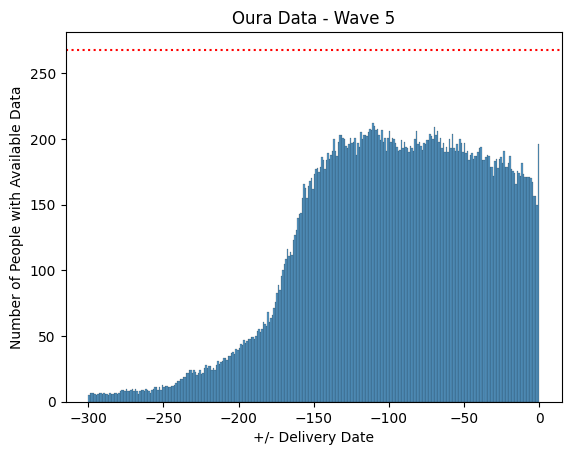

In [6]:
def plot_data_frequency(birth_df, data_df, start=None, end=None, title=None):
    frequency = []
    for uid in birth_df['user_id'].unique():
        df = data_df.loc[data_df['user_id'] == uid].sort_values(by='date')
        if len(df) > 0:
            birth_date = birth_df.loc[birth_df['user_id'] == uid]['birth_date'].tolist()[0]
            if start != None:
                df = df[(df['date'] >= birth_date + pd.to_timedelta(-start, unit='d'))]
            if end != None:
                df = df[(df['date'] <= birth_date + pd.to_timedelta(end, unit='d'))]
            # df = df.dropna()
            df['int_time'] = df['date'].apply(lambda x: (x - birth_date).days)
            if len(df['int_time'].unique()) == len(df):
                frequency.extend(df['int_time'].tolist())
    bin_num = max(frequency) - min(frequency)
    sns.histplot(data=np.array(frequency), bins=bin_num)
    plt.xlabel('+/- Delivery Date')
    plt.ylabel('Number of People with Available Data')
    plt.axhline(y=len(birth_df), color='r', linestyle=':')
    if title != None:
        plt.title(title)
plot_data_frequency(birth_df, oura_df, start=300, end=0, title='Oura Data - Wave 5')

In [7]:
def fill_in_missing_dates(df, date_col_name = 'date', start_date=None, end_date=None, fill_val = np.nan, date_format='%Y-%m-%d'):
    df.set_index(date_col_name,drop=True,inplace=True)
    df.index = pd.to_datetime(df.index, format = date_format)
    idx = pd.date_range(start_date, end_date)
    # print('missing_dates are',idx.difference(df.index))
    df=df.reindex(idx,fill_value=fill_val)
    return df

In [30]:
processed_data = defaultdict(list,{ k:[] for k in oura_sleep_list + ['user_id', 'missingness'] })
processed_data_total = []
before_days = 30
after_days = 7
for uid in birth_df['user_id'].unique():
    df = oura_df.loc[oura_df['user_id'] == uid].sort_values(by='date')
    if len(df) > 0:
        birth_date = birth_df.loc[birth_df['user_id'] == uid]['birth_date'].tolist()[0]
        birth_scheduled = birth_df.loc[birth_df['user_id'] == uid]['birth_scheduled'].tolist()[0]
        if birth_scheduled == 2:
            start_date = birth_date + pd.to_timedelta(-before_days + 1, unit='d')
            end_date = birth_date + pd.to_timedelta(after_days, unit='d')
            df = df[(df['date'] >= start_date)]
            df = df[(df['date'] <= end_date)]
            if len(df) >= round((before_days + after_days) * 0.8):
                # print(df['date'].min(), df['date'].max(), birth_date)
                # if len(df) != before_days + after_days:
                processed_data['missingness'].append(round((len(df) / (before_days + after_days)), 2))
                df=fill_in_missing_dates(df, date_col_name='date', start_date=start_date, end_date=end_date)
                for col in oura_sleep_list:
                    processed_data[col].append(df[col].tolist())
                df = df.interpolate(method='linear', limit_direction='forward', axis=0)
                df = df.ffill(axis=0)
                processed_data['user_id'].append(uid)
                processed_data_total.append(df[oura_sleep_list].to_numpy())
processed_data_total = np.stack(processed_data_total)

In [31]:
len(processed_data_total)

42

In [73]:
before_days = 40
filter_range = np.linspace(0,1,21) # % Missingness
number_of_samples = [0] * len(filter_range)
for i, threshold in enumerate(filter_range):
    for uid in birth_df['user_id'].unique():
        df = oura_df.loc[oura_df['user_id'] == uid].sort_values(by='date')
        if len(df) > 0:
            start_date = birth_date + pd.to_timedelta(-before_days + 1, unit='d')
            df = df[(df['date'] >= start_date)]
            df = df[(df['date'] <= birth_date)]
            if len(df) >= round(before_days * threshold):
                number_of_samples[i] += 1

KeyboardInterrupt: 

Text(0.12, 0.01, '\n    Missingness threshold is cutoff percentage of missingness. E.g. When the missingness threshold is at 80%, \n    it shows how many people have data avaliable for at least 80% of the given time period.')

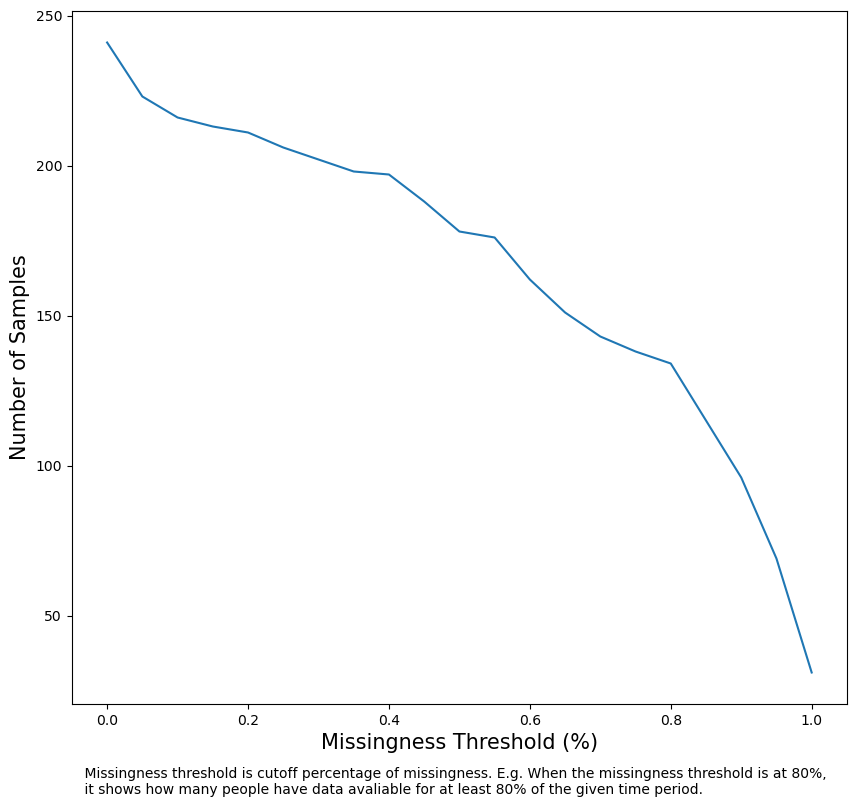

In [12]:
txt = '''
    Missingness threshold is cutoff percentage of missingness. E.g. When the missingness threshold is at 80%, 
    it shows how many people have data avaliable for at least 80% of the given time period.'''

fig, ax1 = plt.subplots()
fig.set_size_inches(10, 9)
ax1.set_xlabel('Missingness Threshold (%)', fontsize=15)
ax1.set_ylabel('Number of Samples', fontsize=15)
ax1.plot(filter_range, number_of_samples)
fig.text(.12, .01, txt)
plt.show()

In [26]:
for uid in processed_data['user_id']:
    newpath = f'/repos/Delivery-Readiness/data/selected_feature_set_d/bump_user_{int(uid)}' 
    if not os.path.exists(newpath):
        os.makedirs(newpath)

In [32]:
with open(f'/repos/Delivery-Readiness/data/raw_data_with_missingness/selected_feature_set_d.pkl', 'wb') as handle:
    pickle.dump(processed_data, handle)

In [20]:
#each feature
for col in oura_sleep_list:
    for i in range(len(processed_data[col])):
        uid = processed_data['user_id'][i]
        with open(f'/repos/Delivery-Readiness/data/selected_feature_set_b/bump_user_{int(uid)}/{col}_0.pkl', 'wb') as handle:
            pickle.dump(np.array([processed_data[col][i]]).T, handle)

In [22]:
processed_data_total.shape

(2, 27, 11)

In [108]:
scale_processed_data_total = np.zeros_like(processed_data_total)
for i in range(processed_data_total.shape[2]):
    scaler = MinMaxScaler().fit(processed_data_total[:,:,i])
    scale_processed_data_total[:,:,i] = scaler.transform(processed_data_total[:,:,i])
    scale_processed_data_total[:,:,i] = scaler.transform(processed_data_total[:,:,i])
    scale_processed_data_total[:,:,i] = scaler.transform(processed_data_total[:,:,i])

In [27]:
#all feature
for i in range(processed_data_total.shape[0]):
    uid = processed_data['user_id'][i]
    with open(f'/repos/Delivery-Readiness/data/selected_feature_set_d/bump_user_{int(uid)}/user_original_0.pkl', 'wb') as handle:
        pickle.dump(np.array(processed_data_total[i]), handle)
    # with open(f'/repos/Delivery-Readiness/data/selected_feature_set_b/bump_user_{int(uid)}/user_minmax_0.pkl', 'wb') as handle:
    #     pickle.dump(np.array(scale_processed_data_total[i]), handle)

In [64]:
processed_data_total.shape

(53, 47, 11)

In [19]:
processed_data['user_id'].index(2083)

30

In [31]:
processed_data_total.shape

(53, 47, 6)

In [35]:
processed_data_total[30][30][1] = (processed_data_total[30][29][1] + processed_data_total[30][31][1])/2

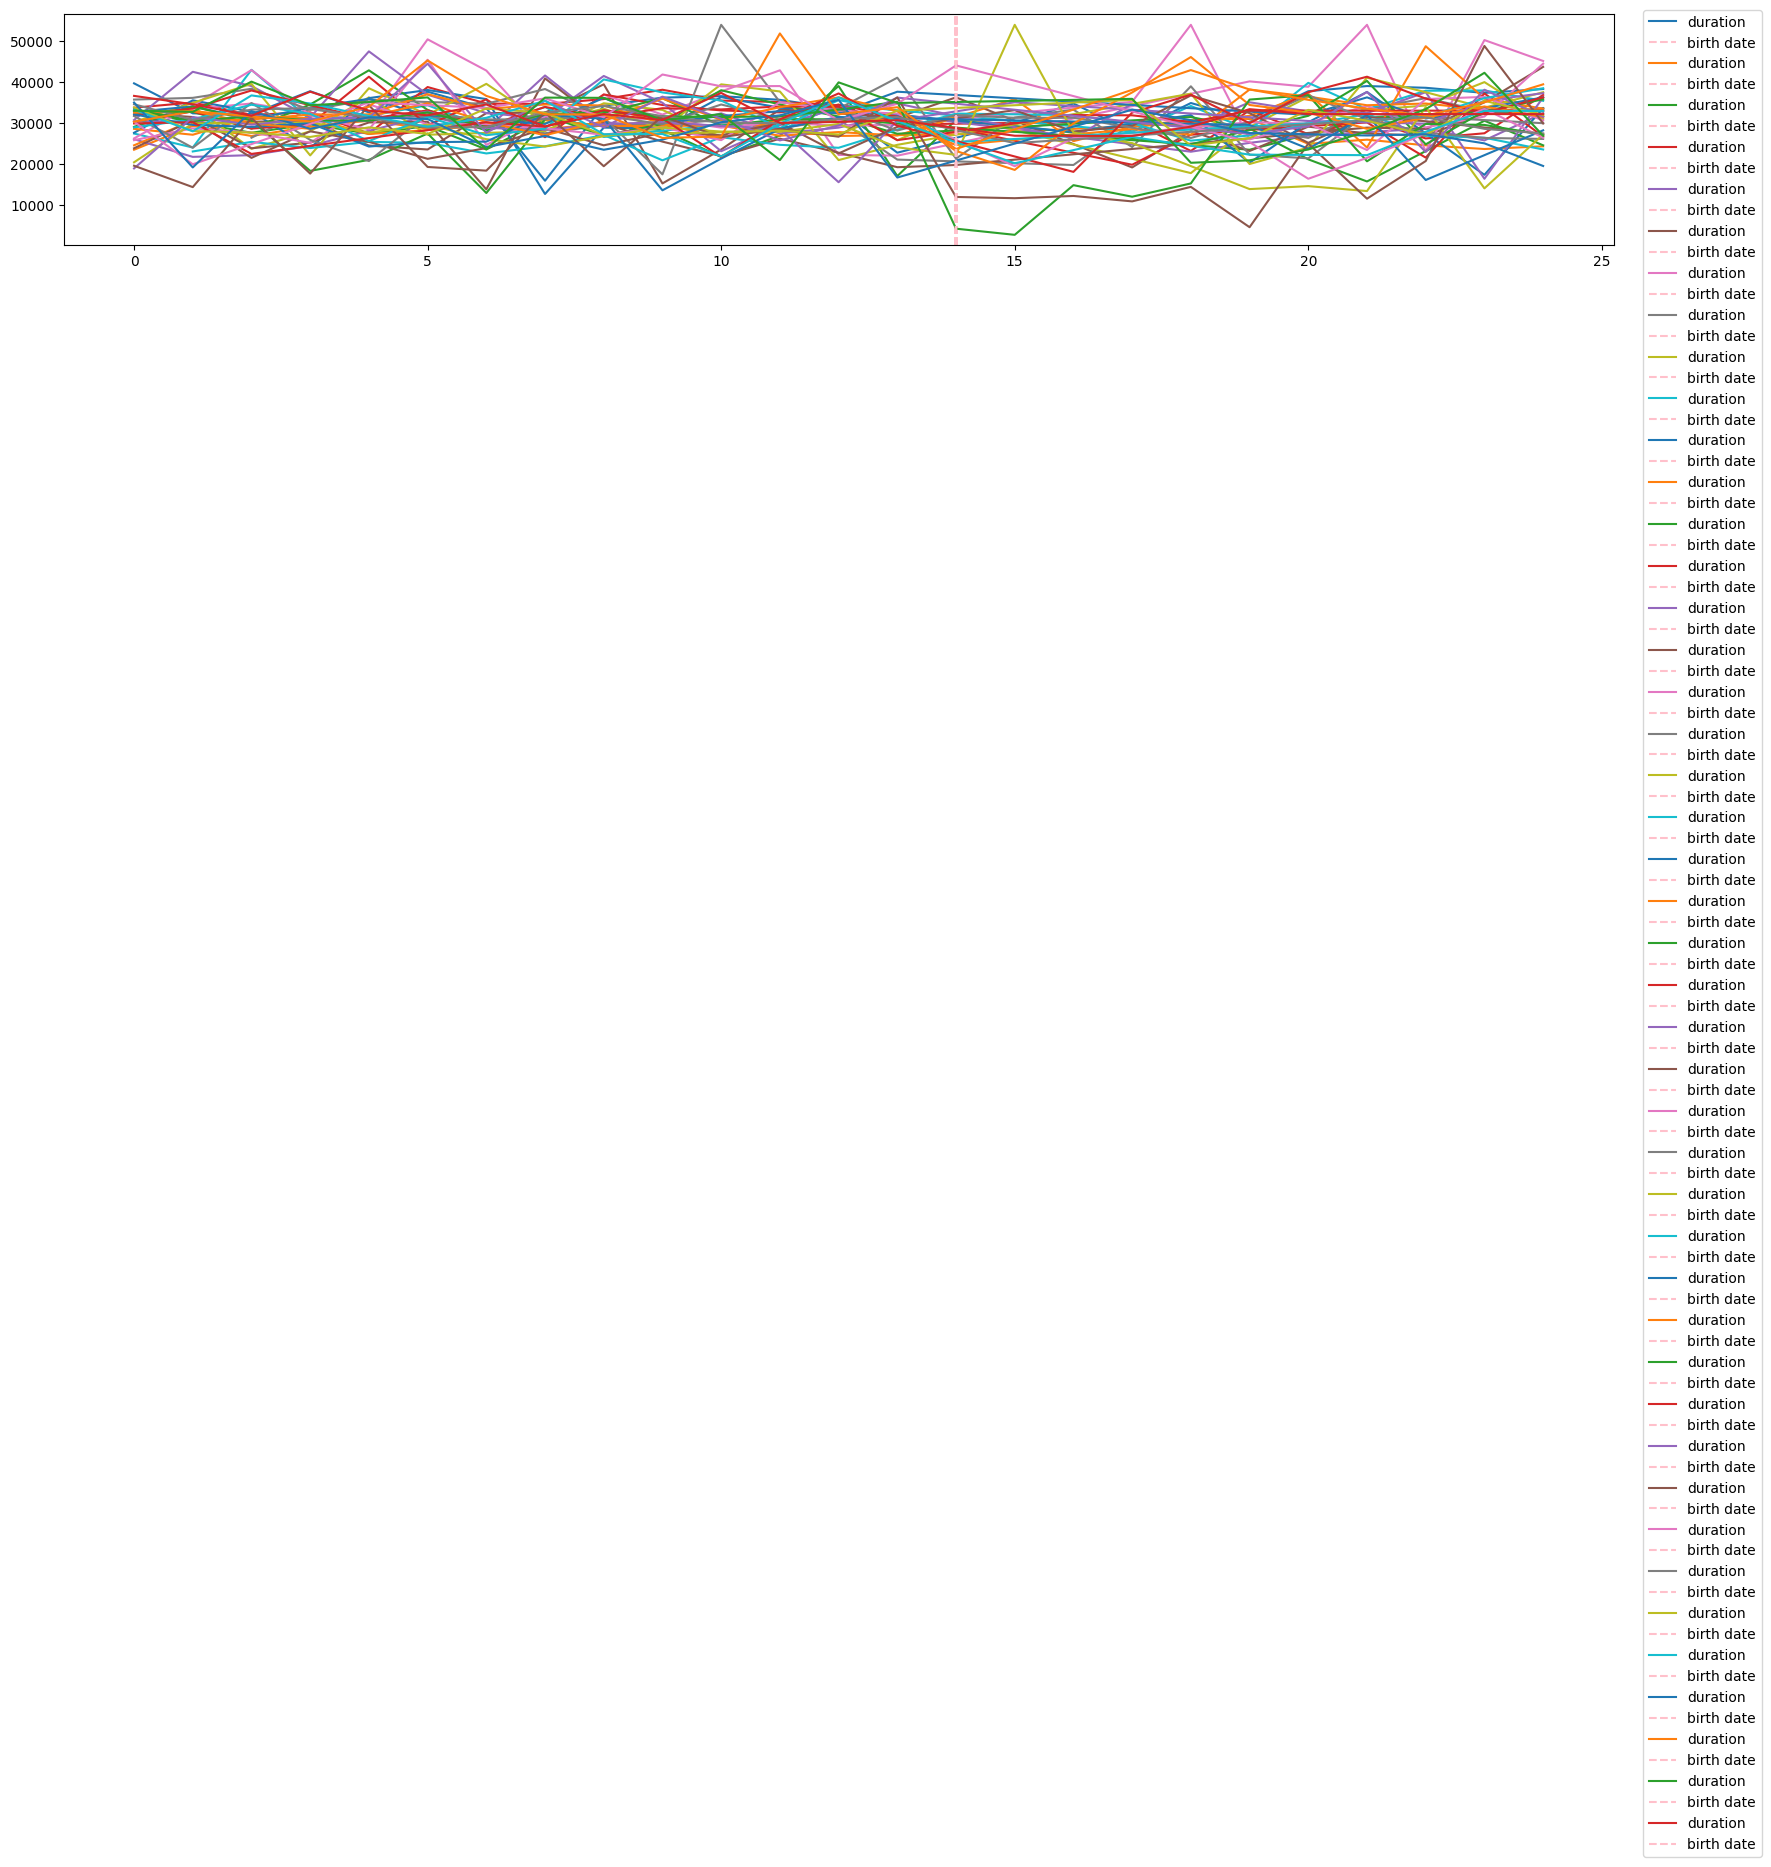

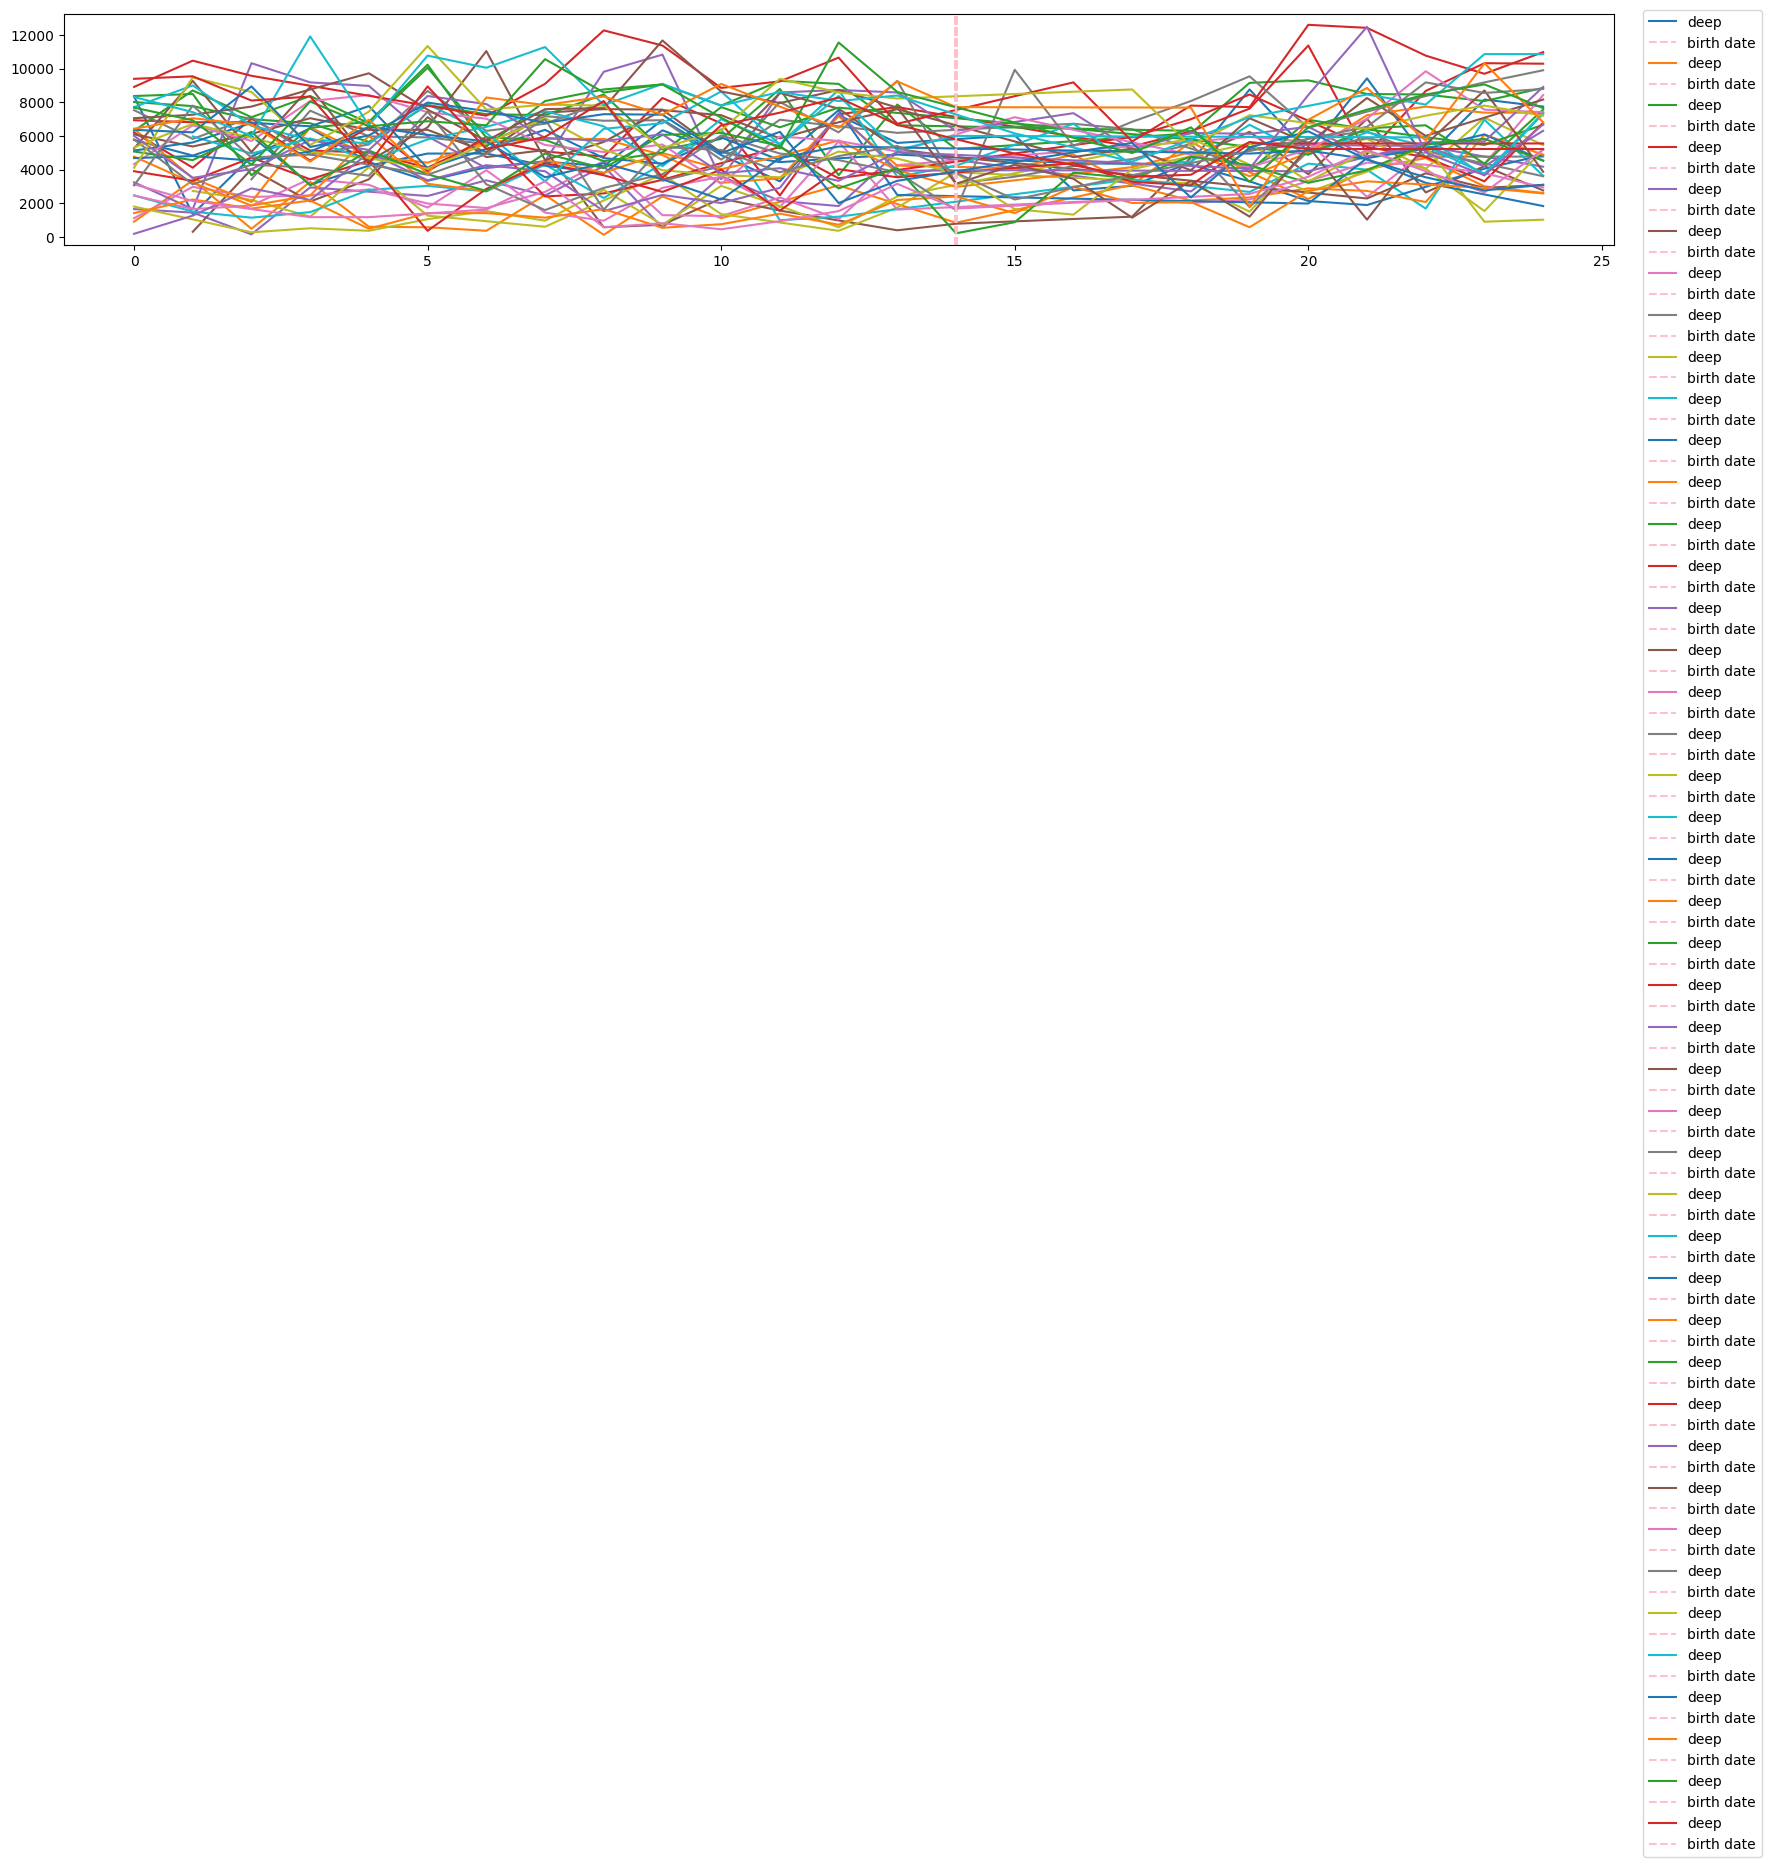

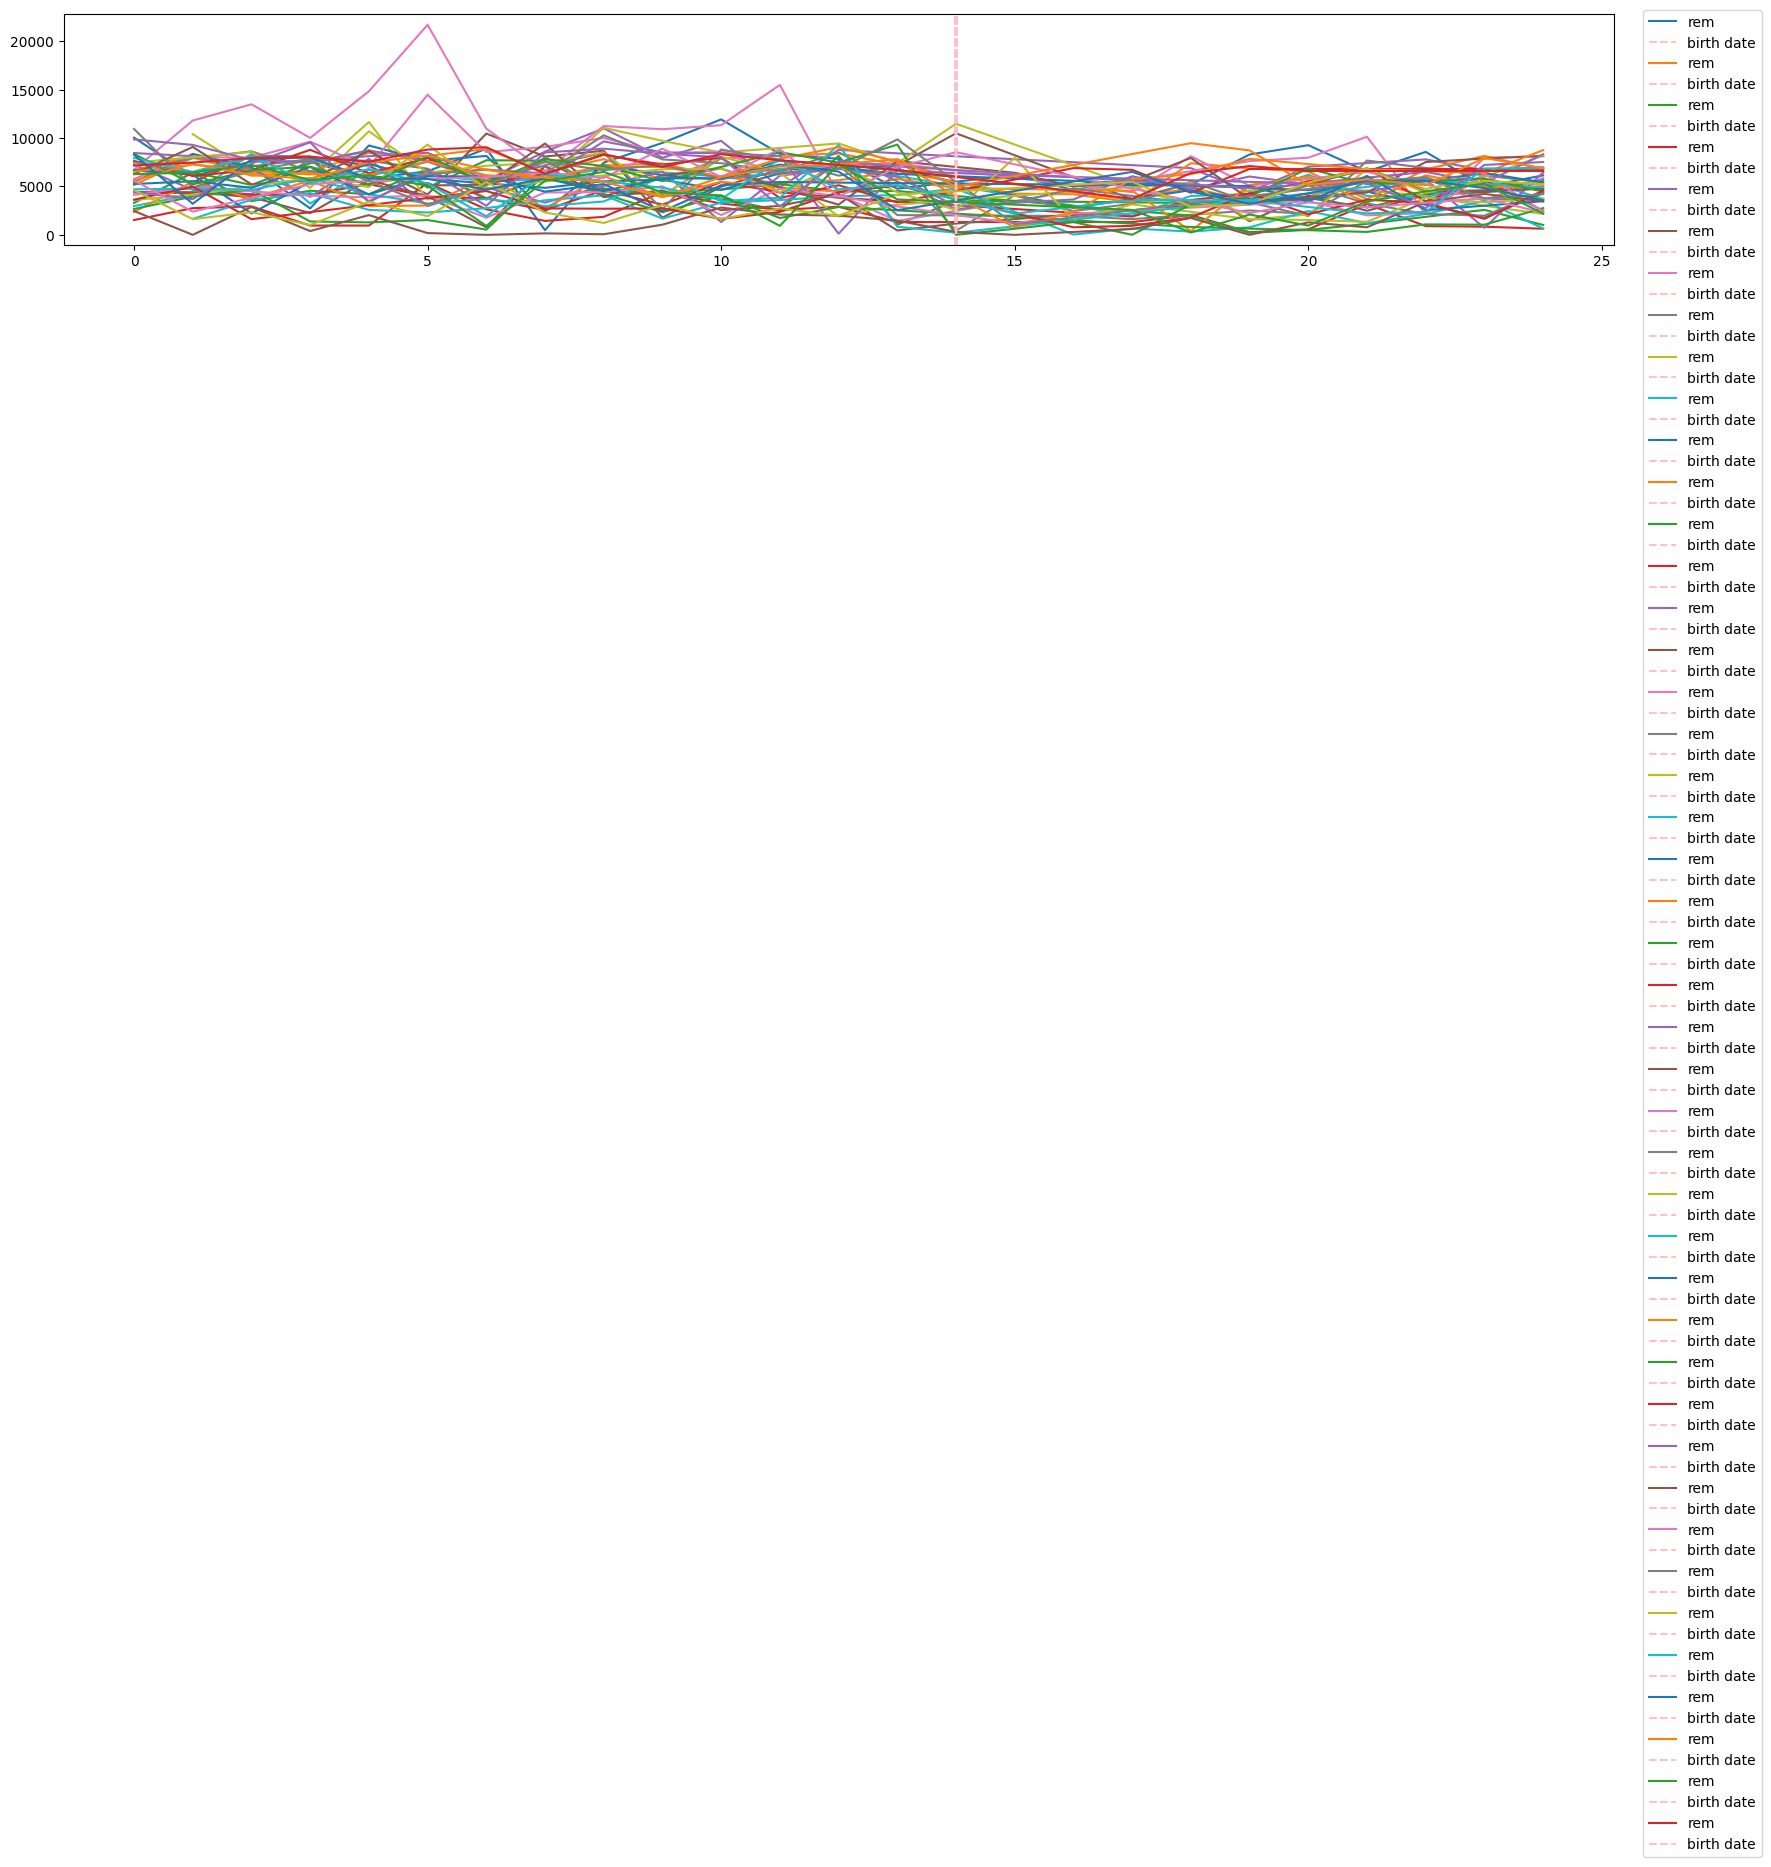

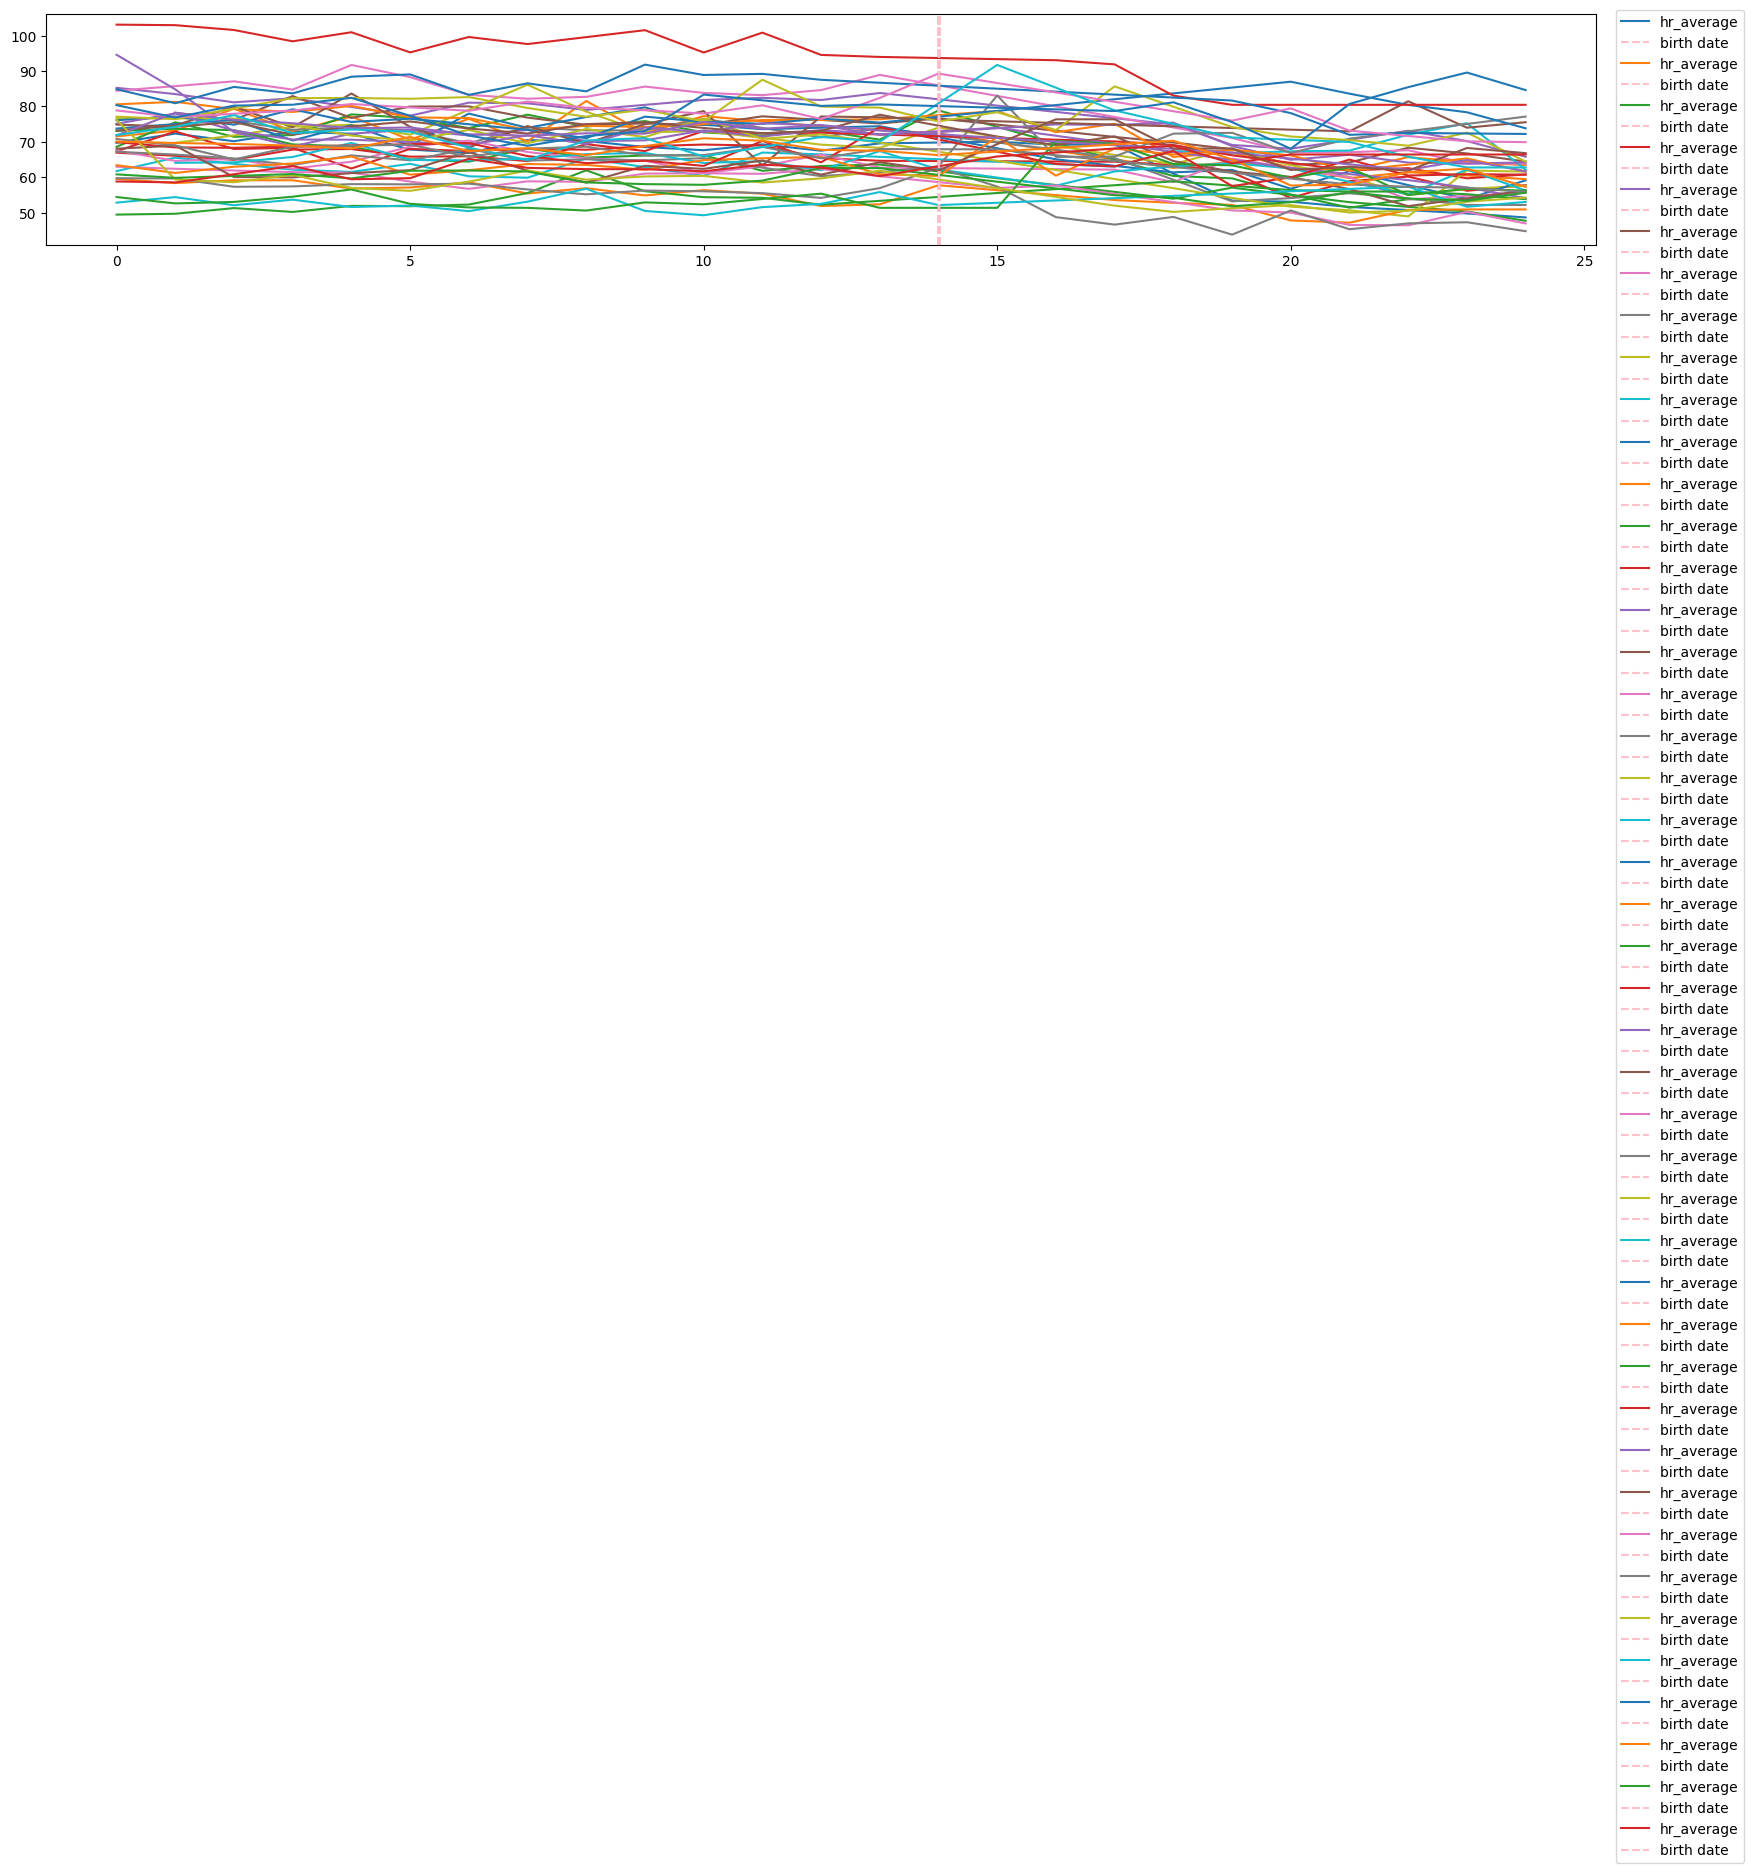

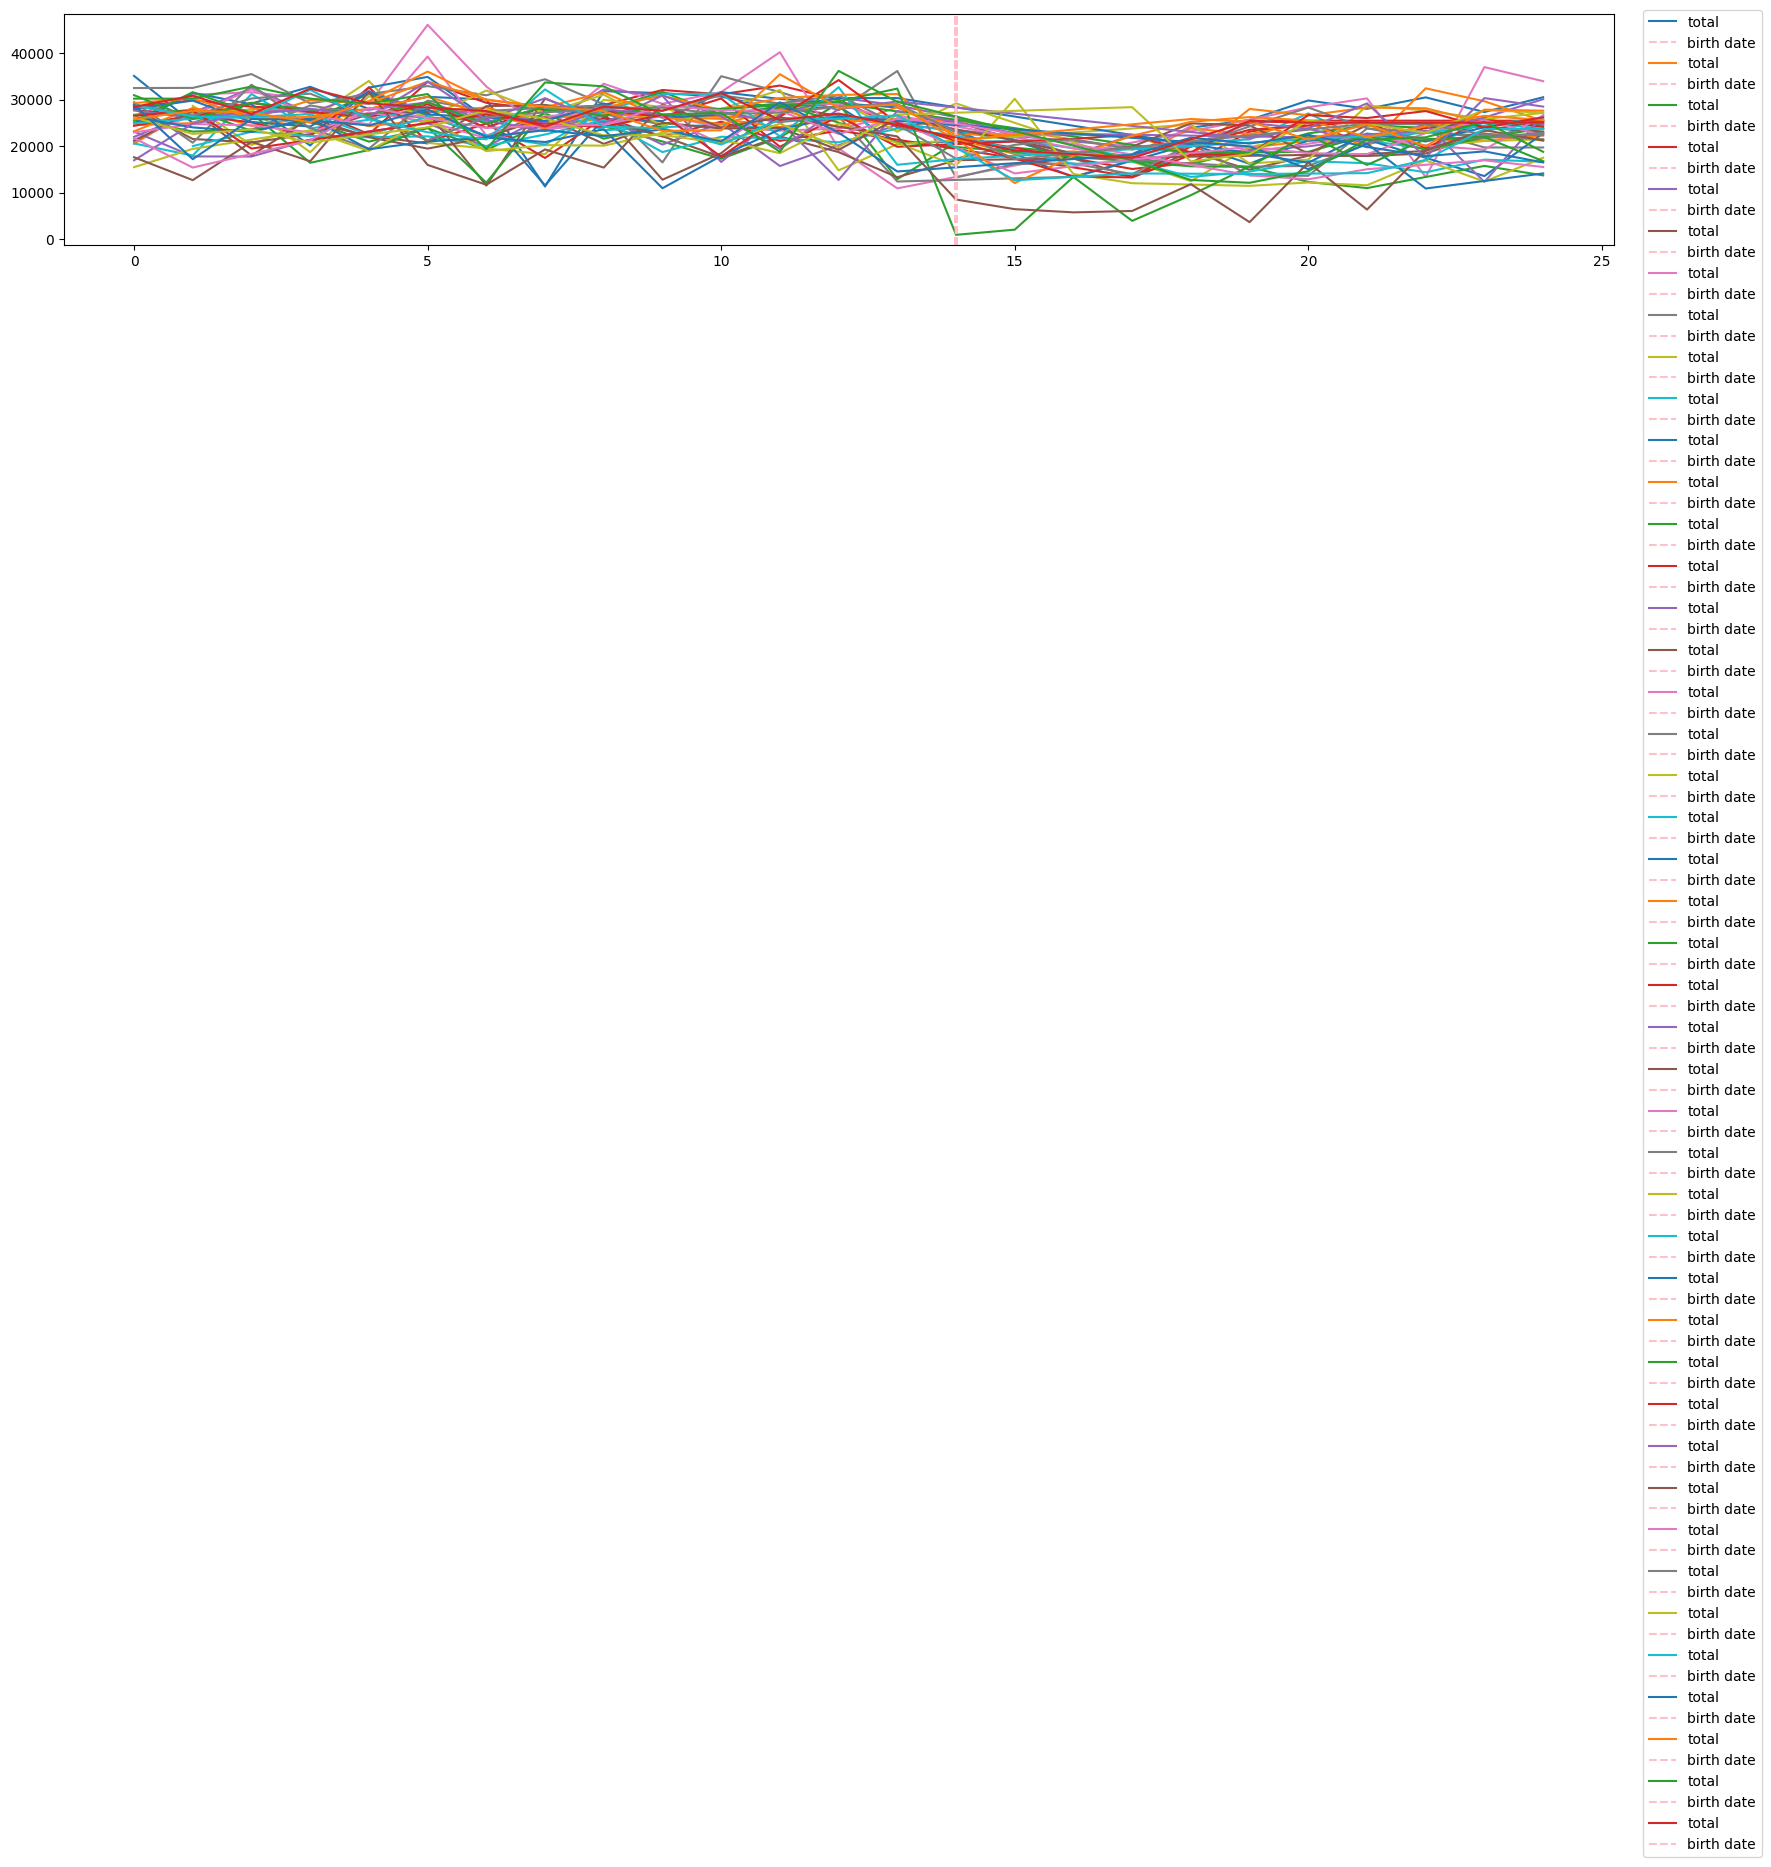

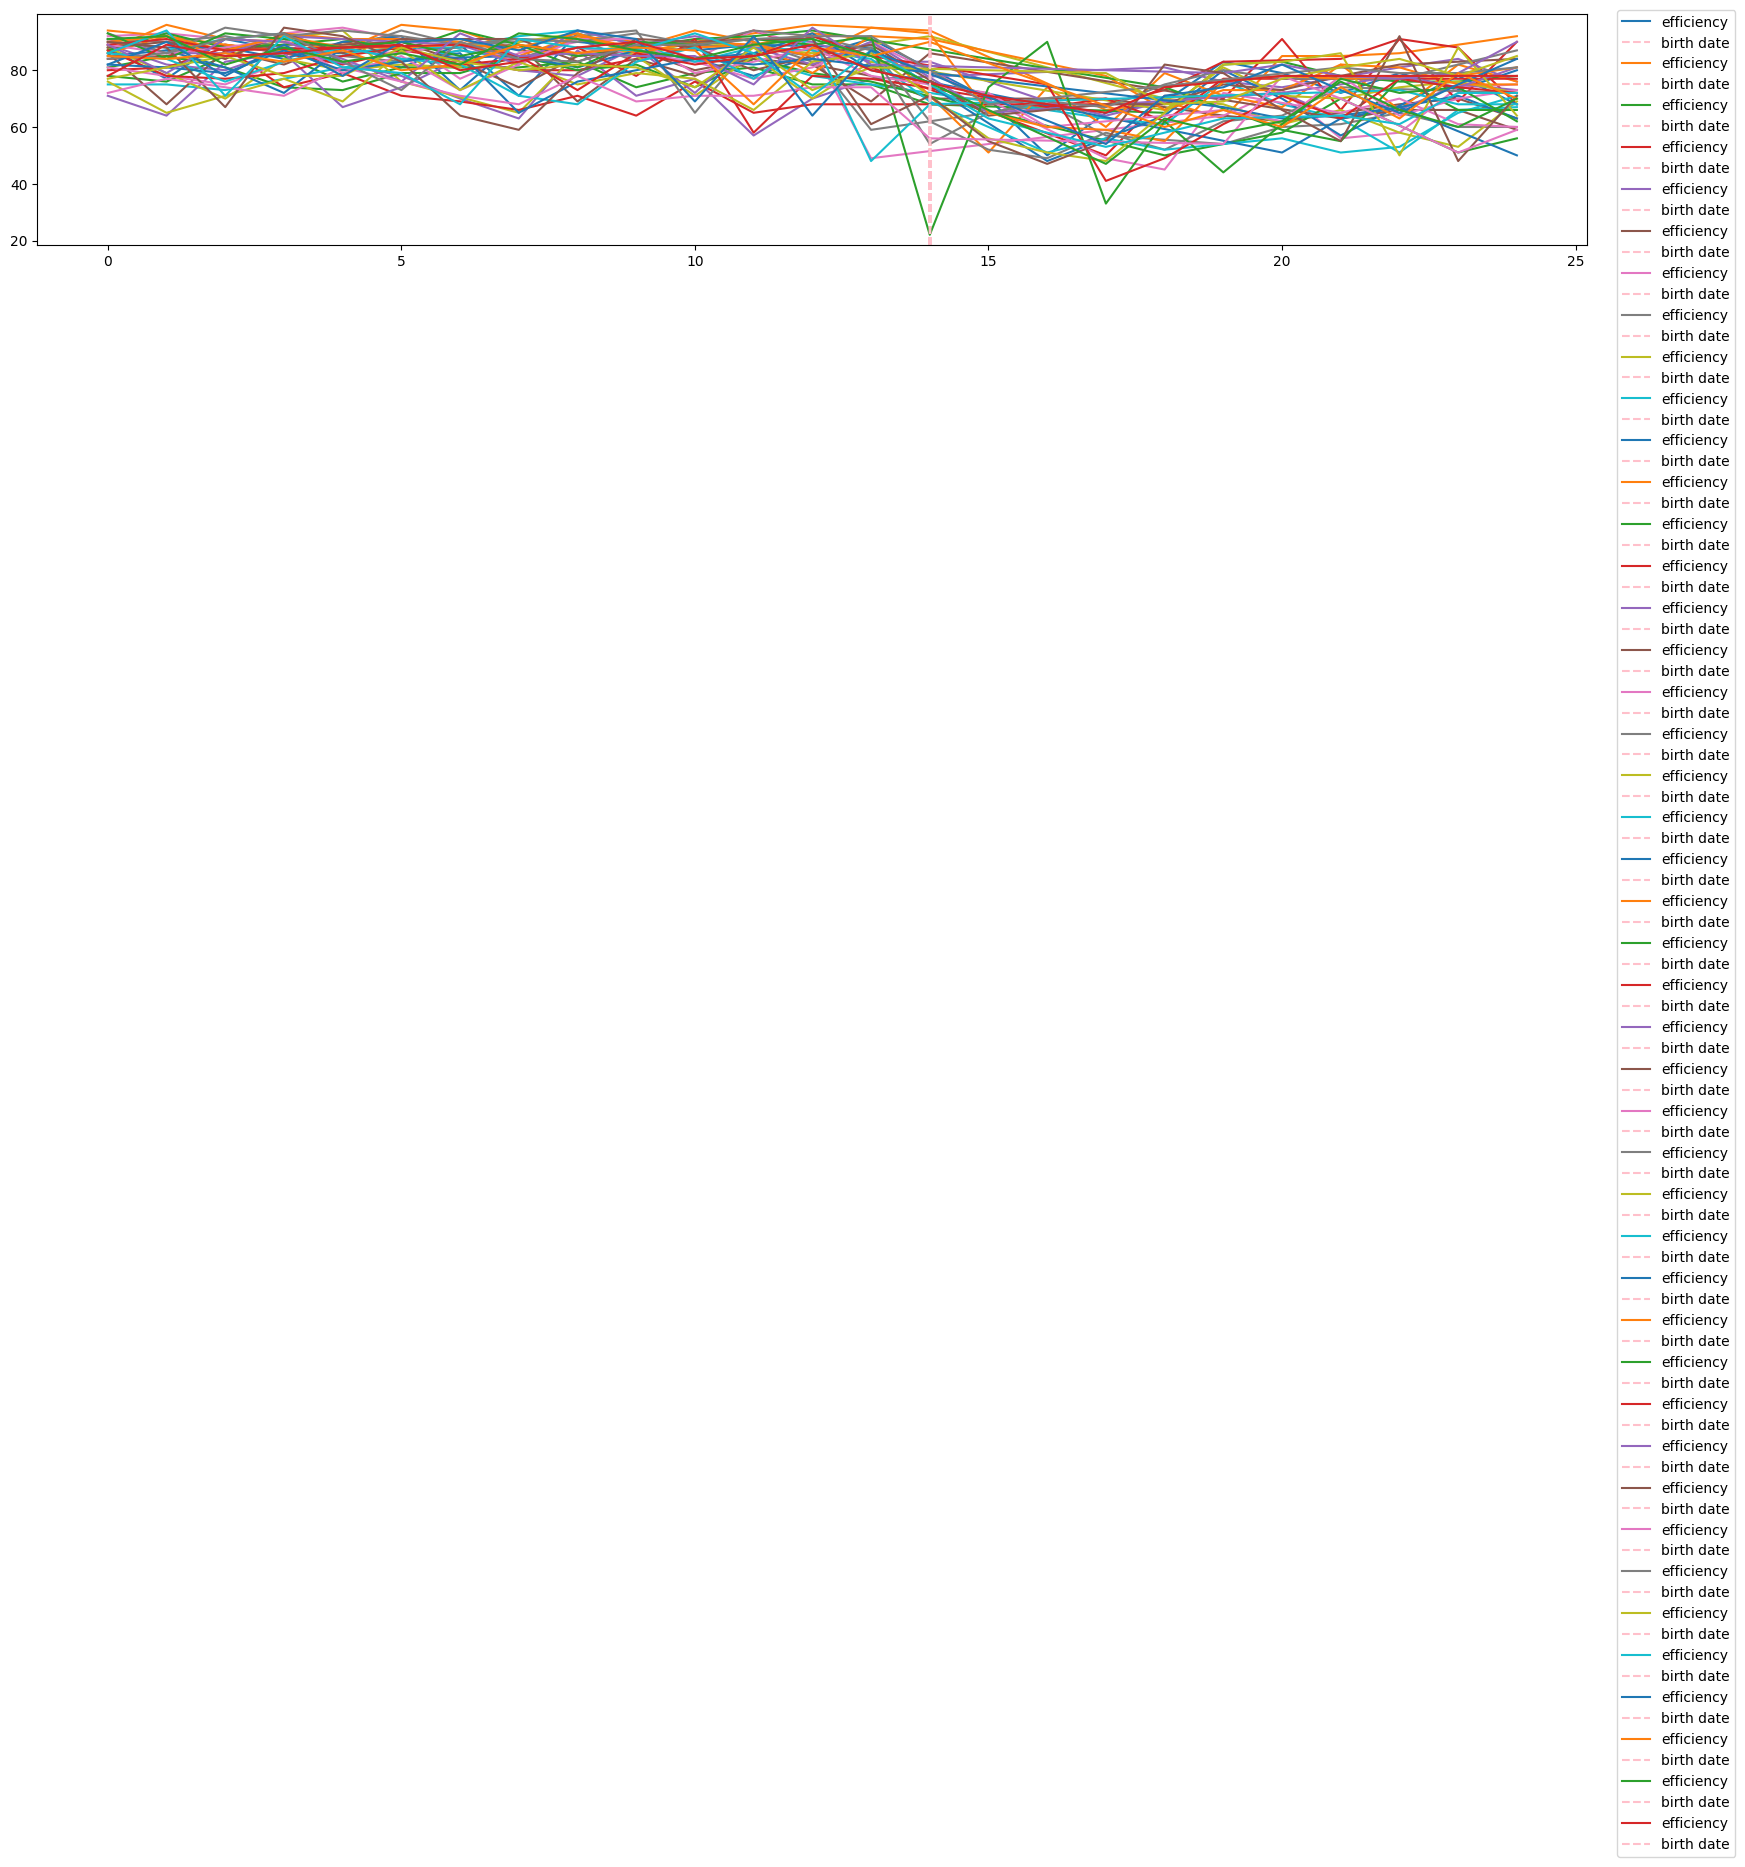

In [72]:
user_index = 0
for i in range(processed_data_total[user_index].shape[1]):
    for user_index in range(len(processed_data['user_id'])):
        # print(processed_data['user_id'][user_index])
        plt.rcParams["figure.figsize"] = (20,3)
        plt.plot(processed_data_total[user_index][:,i], label=oura_sleep_list[i])
        plt.axvline(x=before_days - 1, color='pink', ls='--', label='birth date')
        plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()